In [1]:
import os
os.chdir("../../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import wigpy

from src.tsa.ts_utils import *
from src.text.epu import *
from src.text.utils import *
from statsmodels.tsa.api import VAR

In [2]:
nlp = spacy.load("en_core_web_sm")
folderpath = os.getcwd() + "/data/text/solomon_islands/"

In [3]:
files_list = [
    folderpath + file for file in os.listdir(folderpath)
    if "news" in file and "ner" not in file
]
region_nps = [os.getcwd() + "/data/text/abc_au/solomon_islands_abc_news.csv",
             os.getcwd() + "/data/text/rnz/solomon_islands_rnz_news.csv"]

files_list.extend(region_nps)

In [4]:
epu_df = pd.DataFrame()
for file, nn in zip(files_list, ["sibc", "ss", "st", "tis", "abc", "rnz"]):
    epu = EPU(filepath=file)
    epu.get_epu_category()
    temp = epu.get_epu_stats(cutoff="2020-01-01")
    temp.columns = [
        str(nn) + "_" + col if col not in ["date"] else col
        for col in temp.columns
    ]
    if epu_df.empty:
        epu_df = temp
    else:
        epu_df = epu_df.merge(temp, how="outer", on=["date"])

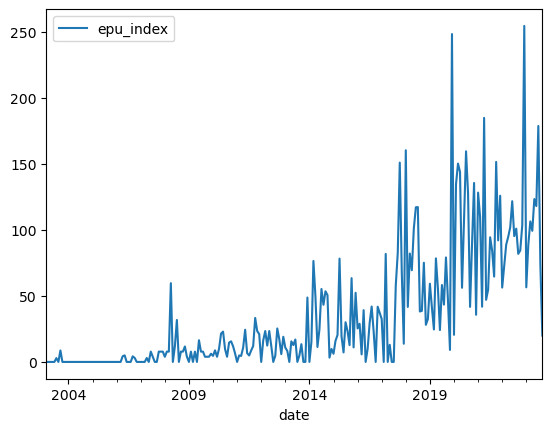

In [7]:
select_cols = [col for col in epu_df.columns  if col.endswith("z_score")]
epu_df = epu_df.sort_values(by="date").reset_index(drop=True).fillna(0)
epu_df["z_score"] = epu_df[select_cols].mean(axis=1)
scaling_factor = 100/(epu_df[epu_df.date >= "2020-01-01"]["z_score"].mean())
epu_df["epu_index"] = epu_df["z_score"] * scaling_factor
epu_df.plot(x="date", y="epu_index");
epu_df.to_csv(os.getcwd() + "/outputs/text/solomon_islands/sib_epu.csv", encoding="utf-8")

In [6]:
def check_entity_in_terms(row, terms):
    nlp = spacy.load('en_core_web_sm')
    if isinstance(row, str):
        doc = nlp(row)
        tokens = [token for token in doc]
        for token in tokens:
            lowered_token = str(token).lower()
            if lowered_token in terms and token.ent_type != 0:
                return True
            else:
                return False
    else:
        return False

## EPU -> Macroeconomic

In [8]:
si_cpi = [
    98.6, 99.0, 100.6, 100.7, 101.0, 100.6, 100.5, 100.1, 99.5, 99.6, 99.5,
    100.3, 102.0, 104.2, 103.9, 103.9, 103.0, 102.8, 103.0, 103.2, 104.0,
    103.8, 104.1, 104.2, 104.5, 103.8, 105.1, 104.2, 104.2, 104.3, 105.0,
    108.0, 105.5, 106.6, 106.9, 106.9, 112.4, 112.7, 112.7, 112.2, 111.1,
    107.2, 105.8, 105.1, 105.4, 105.2, 105.3, 104.1, 106.7, 110.6, 112.4,
    109.8, 109.2, 106.6, 106.1, 106.6, 107.3, 107.5, 107.4, 107.8, 108.8,
    109.4, 109.4, 111.5, 113.9, 114.1, 115.4, 117.1, 118.0, 117.8, 117.2,
    117.0, 118.9, 119.2, 119.8
]

si_infl_df = pd.DataFrame(pd.date_range("2017-01", "2023-03", freq="MS"),
                          columns=["date"])
si_infl_df["cpi"] = si_cpi
si_infl = si_infl_df.merge(epu_df[["date", "epu_index"]], how="left", on="date")
si_infl["inflation"] = (si_infl["cpi"].diff().shift(-1) / si_infl["cpi"]) * 100
si_infl["epu_change"] = (si_infl["epu_index"].diff() /
                         si_infl["epu_index"].shift(1)) * 100

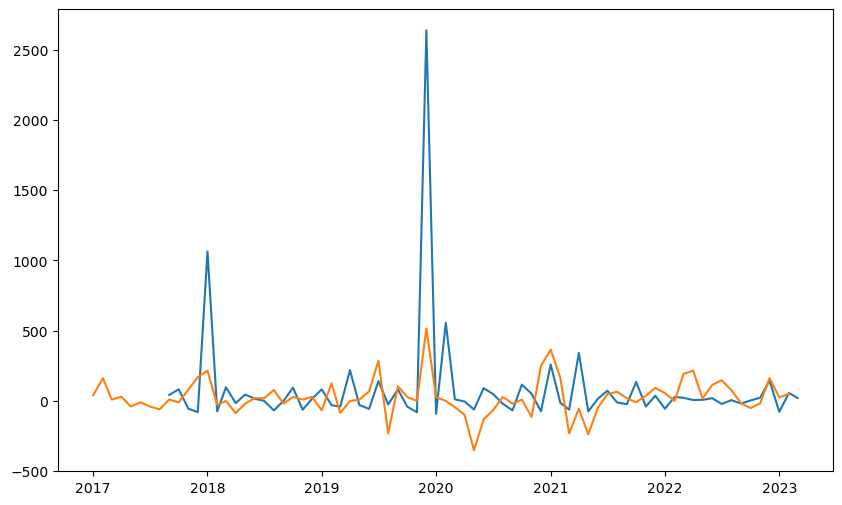

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(si_infl["date"].values, si_infl["epu_change"].values, label="epu_change")
plt.plot(si_infl["date"].values, si_infl["inflation"].values*100, label="inflation");

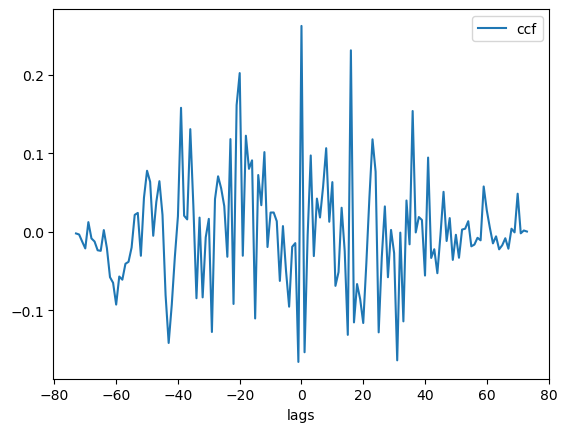

In [10]:
ccf_df = cross_correlation(si_infl["epu_index"][:-1], si_infl["inflation"][:-1])
ccf_df.plot(x="lags");

In [11]:
var_df = si_infl[["inflation", "epu_index"]][:-1].reset_index(drop=True)
print(adf_test(var_df["epu_index"]), "\n", adf_test(var_df["inflation"]))

Test Statistic                 -3.025668
p-value                         0.032566
# Lags Used                     2.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64 
 Test Statistic                -6.971426e+00
p-value                        8.644916e-10
# Lags Used                    0.000000e+00
Number of Observations Used    7.300000e+01
Critical Value (1%)           -3.523284e+00
Critical Value (5%)           -2.902031e+00
Critical Value (10%)          -2.588371e+00
dtype: float64


In [12]:
cointegration_test(var_df)

{'inflation': {'Test Stat': 15.83, 'C(95%)': 12.3212, 'Significance': True},
 'epu_index': {'Test Stat': 0.0, 'C(95%)': 4.1296, 'Significance': False}}

In [13]:
length = len(si_infl.iloc[:])
train = int(length * 0.9)
test = length - train


model = VAR(endog=var_df[:train+1])

eval_lst = []
for i in range(1, 13):
    result = model.fit(i)
    eval_metrics = {
        "lag": i,
        "AIC": result.aic,
        "BIC": result.bic,
        "FPE": result.fpe,
        "HQIC": result.hqic
    }
    eval_lst.append(eval_metrics)
    
eval_df = pd.DataFrame(eval_lst)
eval_df

,lag,AIC,BIC,FPE,HQIC
0,1,8.331944,8.529380,4154.985478,8.410070
1,2,8.390652,8.722417,4408.251155,8.521748
2,3,8.373343,8.841672,4337.353749,8.558129
3,4,8.447063,9.054249,4678.887255,8.686264
4,5,8.587352,9.335748,5402.308286,8.881699
5,6,8.707655,9.599679,6125.901931,9.057886
6,7,8.789858,9.827993,6703.839092,9.196713
7,8,8.869647,10.056442,7343.156000,9.333868
8,9,9.029714,10.367789,8753.749737,9.552045
9,10,8.952291,10.444336,8275.669240,9.533473


In [14]:
best_mod = model.fit(1)
best_mod.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 23, Oct, 2023
Time:                     18:43:11
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    8.52938
Nobs:                     67.0000    HQIC:                   8.41007
Log likelihood:          -463.258    FPE:                    4154.99
AIC:                      8.33194    Det(Omega_mle):         3806.48
--------------------------------------------------------------------
Results for equation inflation
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.717200         0.292183            2.455           0.014
L1.inflation         0.253760         0.122590            2.070           0.038
L1.epu_index        -0.006643         0.003257           -2.

In [15]:
import statsmodels.formula.api as smf
ols_mod = smf.ols("inflation~epu_index", data=var_df)
ols_res = ols_mod.fit()
ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              inflation   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     5.480
Date:                Mon, 23 Oct 2023   Prob (F-statistic):             0.0220
Time:                        18:43:13   Log-Likelihood:                -120.48
No. Observations:                  74   AIC:                             245.0
Df Residuals:                      72   BIC:                             249.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2549      0.268     -0.952      0.344      -0.789       0.279
epu_index      0.0065      0.003      2.341      0.022       0.001       0.012
==============================================================================
Omnibus:                        5.498   Durbin-Watson:                   1.406
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                6.707
Skew:                           0.253   Prob(JB):                       0.0350
Kurtosis:                       4.385   Cond. No.                         176.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
ols_predict = ols_res.fittedvalues
# ols_forecast = ols_res.predict(si_infl["epu_change_1"])
# ols_all = pd.concat([ols_predict, ols_forecast], axis=0)

In [34]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(best_mod.resid)
out

array([1.94594581, 2.00432178])

In [35]:
var_forecast = best_mod.forecast(y=var_df.values[-test:], steps=test)
var_forecast_df = pd.DataFrame(var_forecast, index=var_df.index[-test:], columns=["var_inflation", "var_epu"])

In [37]:
var_df["date"] = pd.date_range(start="2017-01", periods=len(var_df), freq="MS")
fit_df = best_mod.fittedvalues.rename({"epu_index": "var_epu_index",
                                       "inflation": "var_inflation"}, axis=1)
fit_df = pd.concat([fit_df, var_df[1:train+1]], axis=1).reset_index(drop=True)

In [41]:
fit_df

,var_inflation,var_epu_index,inflation,epu_index,date
0,0.599765,171.973711,1.616162,0.000000,2017-02-01
1,1.119407,149.639855,0.099404,189.465159,2017-03-01
2,0.195101,183.576292,0.297915,0.000000,2017-04-01
3,0.789027,168.830837,-0.396040,29.993815,2017-05-01
4,0.528961,180.810217,-0.099404,0.000000,2017-06-01
...,...,...,...,...,...
61,0.231032,183.697845,1.919561,205.714273,2022-03-01
62,0.604600,158.095284,2.152466,219.387518,2022-04-01
63,0.623699,155.560247,0.175593,236.100612,2022-05-01
64,0.080251,185.385289,1.139351,281.890313,2022-06-01


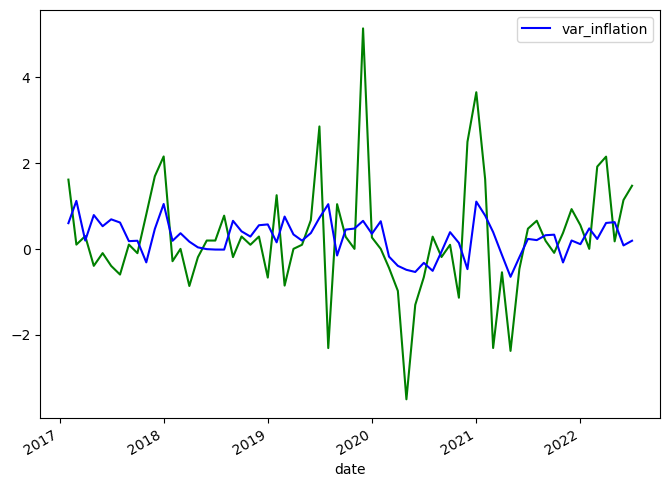

In [42]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fit_df["date"].values, fit_df["inflation"].values, color="green")
fit_df.plot(x="date", y="var_inflation", ax=ax, color="blue")
# ax.plot(var_df["date"][1:].values, ols_all.values)
# ax.plot(var_forecast_df["var_inflation"].index.values,
#         var_forecast_df["var_inflation"].values,
#         label="var_predict_test", color="blue")
# ax.plot(ols_all, color="orange")
plt.show();